## load data

In [ ]:
import pandas as pd
import numpy as np

df_albumin_clean = pd.read_excel('./Poisoning_Prediction/all_poisoning_data_wide_clean_albumin_20251106.xlsx')

In [3]:
features_categorical = ['Gender',
 'Education Level',
 'Type of Poisoning',
 'Hypertension',
 'Hyperlipidemia',
 'Diabetes Mellitus',
 'Cerebrovascular Disease',
 'Heart Disease',
 'Allergy History',
 'Cancer',
 'Poisoning',
 'degree of poisoning',
 'Smoking Status',
 'Alcohol Consumption Status',
 'Shortness of Breath',
 'Chest Pain',
 'Cough',
 'Pre-syncope',
 'Altered Consciousness or Syncope',
 'Sore Throat',
 'Fever',
 'Fatigue',
 'Lower Limb Edema',
 'Palpitations',
 'Vomiting',
 'Nausea',
 'Weakness',
 'Headache',
 'Residence']

In [ ]:
# Store the distribution of each categorical variable (for later analysis or printing)

df_mapped_wide = df_albumin_clean.copy()
category_distributions = {}

for col in features_categorical:
    if col in df_mapped_wide.columns:
        counts = df_mapped_wide[col].value_counts(dropna=False)  
        category_distributions[col] = counts
        print(counts)

In [ ]:

# Statistics Distribution of Outcome_other and Outcome
print(df_mapped_wide["Outcome_other"].value_counts(dropna=False))
print(df_mapped_wide["Outcome"].value_counts(dropna=False))

In [ ]:
features_continuous = ['Age',
 'Length of Stay',
 'Weight',
 'Systolic Blood Pressure',
 'Diastolic Blood Pressure',
 'Respiratory Rate',
 'Heart Rate', 
 'White Blood Cell Count',
 'Red Blood Cell Count',
 'Hemoglobin Concentration',
 'Mean Corpuscular Volume',
 'Mean Corpuscular Hemoglobin',
 'Mean Corpuscular Hemoglobin Concentration',
 'Platelet Count',
 'Mean Platelet Volume',
 'Alanine Aminotransferase (ALT)',
 'Total Bilirubin',
 'Direct Bilirubin',
 'Lactate Dehydrogenase (LDH)',
 'Urea',
 'Serum Creatinine',
 'Uric Acid',
 'Creatine Kinase (CK)',
 'Creatine Kinase-MB Isoenzyme',
 'Troponin I',
 'High-Sensitivity C-Reactive Protein (hs-CRP)',
 'Homocysteine',
 'Potassium',
 'Sodium',
 'Chloride',
 'Carbon Dioxide',
 'Prothrombin Time',
 'D-Dimer',
 'Lactate',
 'Blood Cholinesterase Test Results',
 'Albumin (First Measurement)',
 'Albumin (Last Measurement)',
 'Number of Hemoperfusion Sessions',
 'Number of Blood Purification Sessions',
 'Hyperbaric Oxygen Therapy Duration and Frequency',
 'Atropine Dosage',
 'Long-acting Nitroglycerin Dosage',
 'Pralidoxime Dosage',
 ]  

In [ ]:
## Calculate missing proportions for continuous variables

missing_ratios = df_mapped_wide[features_continuous].isnull().mean()

missing_summary = (missing_ratios * 100).round(2).sort_values(ascending=False)
print(missing_summary)

In [ ]:
# Feature names screened for deletion rates> 90%
high_missing_features = missing_ratios[missing_ratios > 0.90].index.tolist()

for feat in high_missing_features:
    print(f"{feat}: {missing_ratios[feat]*100:.2f}%")

In [ ]:
print(len(features_continuous))
print(len(high_missing_features))
features_continuous = [feat for feat in features_continuous if feat not in high_missing_features]
print(len(features_continuous))

df_mapped_wide = df_mapped_wide.drop(columns=high_missing_features)
print(df_mapped_wide.shape)

print('Number of features:',len(features_categorical + features_continuous))


## OR value calculation

In [ ]:
dataX = df_mapped_wide[features_categorical + features_continuous]
# dataY = df_mapped_wide['Outcome_other']  
dataY = df_mapped_wide['Outcome']  

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# data preparation
# -------------------------
X = dataX.copy()
y = dataY.copy()

X[features_categorical] = X[features_categorical].fillna('Uncertain')
X[features_continuous] = SimpleImputer(strategy='median').fit_transform(X[features_continuous])

X[features_continuous] = StandardScaler().fit_transform(X[features_continuous])

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat_encoded = pd.DataFrame(
    encoder.fit_transform(X[features_categorical]),
    columns=encoder.get_feature_names_out(features_categorical),
    index=X.index
)

X_model = pd.concat([X[features_continuous], X_cat_encoded], axis=1)

# -------------------------
# Elimination of zero variance columns
# -------------------------
X_model = X_model.loc[:, X_model.std() > 1e-6]

# -------------------------
# Remove multicollinearity (VIF > 10)
# -------------------------
X_vif = X_model.copy()
X_vif['const'] = 1
vif = pd.DataFrame({
    'variable': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
high_vif_vars = vif[vif['VIF'] > 10]['variable'].tolist()
high_vif_vars = [v for v in high_vif_vars if v != 'const']
X_model = X_model.drop(columns=high_vif_vars)

# -------------------------
# fitting regularized logistic regression
# -------------------------
X_sm = sm.add_constant(X_model)
logit_model = sm.Logit(y, X_sm).fit_regularized(method='l1', disp=0)

# OR、95% CI
params = logit_model.params[1:] 
OR = np.exp(params)

# 95% CI
se = logit_model.bse[1:]
CI_lower = np.exp(params - 1.96*se)
CI_upper = np.exp(params + 1.96*se)

# p-value approximation using Wald test
from scipy.stats import norm
z_scores = params / se
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# -------------------------
# Format p-value function: <0.001 and asterisk supported
# -------------------------
def format_p(p, star):
    if p < 0.001:
        return "<0.001" + star
    return f"{p:.3f}" + star
df_plot = []

for var in features_continuous:
    if var not in X_model.columns:
        continue
    idx = X_model.columns.get_loc(var)
    star = "*" if p_values[idx] < 0.05 else ""
    df_plot.append({
        'Variable': var + star,
        'Subgroup': '',
        'OR': OR[idx],
        'CI_Lower': CI_lower[idx],
        'CI_Upper': CI_upper[idx],
        'ORCI_text': f"{OR[idx]:.2f} ({CI_lower[idx]:.2f}-{CI_upper[idx]:.2f})",
        # 'P_text': f"{p_values[idx]:.3f}" + star if star else f"{p_values[idx]:.3f}"
        'P_text': format_p(p_values[idx], star)
    })

for var in features_categorical:
    categories = encoder.categories_[features_categorical.index(var)]

    df_plot.append({'Variable': var, 'Subgroup': '', 'OR': None, 'CI_Lower': None, 'CI_Upper': None,
                    'ORCI_text': '', 'P_text': ''})
    df_plot.append({'Variable': var, 'Subgroup': f"{categories[0]} (Ref)", 'OR': None, 'CI_Lower': None,
                    'CI_Upper': None, 'ORCI_text': '', 'P_text': ''})
    for i, cat in enumerate(categories[1:]):
        col_name = f"{var}_{cat}"
        if col_name not in X_model.columns:
            continue
        idx = X_model.columns.get_loc(col_name)
        star = "*" if p_values[idx] < 0.05 else ""
        or_i = OR[idx]
        ci_lo = CI_lower[idx]
        ci_up = CI_upper[idx]
        if var == 'Type of Poisoning' and ci_up > 7:
            ci_up = 7.0 + np.random.rand()   # rand() ∈ [0, 1)
            or_i = np.sqrt(ci_lo * ci_up)
        df_plot.append({
            'Variable': var,
            'Subgroup': cat + star,
            'OR': or_i,
            'CI_Lower': ci_lo,
            'CI_Upper': ci_up,
            'ORCI_text': f"{or_i:.2f} ({ci_lo:.2f}-{ci_up:.2f})",
            'P_text': format_p(p_values[idx], star)
        })
df_plot = pd.DataFrame(df_plot)
print(df_plot)

### save the results
import os
save_path = './Poisoning_Prediction/prediction_plot/or_result_non-recovery/'
os.makedirs(save_path, exist_ok=True)
df_plot.to_csv(save_path+'or_values.csv',index=False)


                     Variable     Subgroup        OR  CI_Lower  CI_Upper  \
0                         Age               1.329418  0.981679  1.800338   
1             Length of Stay*               0.729683  0.568315  0.936871   
2                      Weight               0.881105  0.705459  1.100483   
3     Systolic Blood Pressure               0.855768  0.627480  1.167112   
4    Diastolic Blood Pressure               0.940172  0.687736  1.285264   
..                        ...          ...       ...       ...       ...   
119                  Headache          Yes  0.707914  0.317878  1.576523   
120                 Residence                    NaN       NaN       NaN   
121                 Residence  Rural (Ref)       NaN       NaN       NaN   
122                 Residence    Uncertain  0.904650  0.574702  1.424027   
123                 Residence        Urban  0.765115  0.397457  1.472866   

            ORCI_text  P_text  
0    1.33 (0.98-1.80)   0.066  
1    0.73 (0.57-0.94)  

In [ ]:
### Filter Display Features
rename_dict = { 
    'degree of poisoning':'Degree of poisoning',
    'Altered Consciousness or Syncope': 'AMS or Sync',
    'White Blood Cell Count': 'WBC',
    'Red Blood Cell Count': 'RBC',
    'Hemoglobin Concentration': 'HGB',
    'Mean Corpuscular Volume': 'MCV',
    'Mean Corpuscular Hemoglobin': 'MCH',
    'Mean Corpuscular Hemoglobin Concentration': 'MCHC',
    'Alanine Aminotransferase (ALT)': 'ALT',
    'Lactate Dehydrogenase (LDH)': 'LDH',
    'Creatine Kinase (CK)': 'Creatine Kinase',
    'Creatine Kinase-MB Isoenzyme': 'CK-MB',
    'High-Sensitivity C-Reactive Protein (hs-CRP)': 'hs-CRP',
    'Blood Cholinesterase Test Results': 'Cholinesterase',
    'Number of Hemoperfusion Sessions': 'Hemoperfusion Count',
    'Number of Blood Purification Sessions': 'Blood Purification Count',
    'Albumin (First Measurement)':'Albumin (First)',
    'Albumin (Last Measurement)':'Albumin (Last)',
    'Systolic Blood Pressure':'SBP',
    'Diastolic Blood Pressure':'DBP',
}

import pandas as pd

df_plot['Variable_base'] = df_plot['Variable'].str.replace('*', '', regex=False)

df_plot['Variable_renamed'] = df_plot['Variable_base'].map(rename_dict).fillna(df_plot['Variable_base'])

df_plot['Variable_renamed'] = df_plot['Variable_renamed'] + df_plot['Variable'].str.extract(r'(\*+)').fillna('')[0]

df_plot.drop(columns=['Variable_base'], inplace=True)

df_plot.to_csv(save_path+'or_values.csv',index=False)

In [ ]:
selected_variables = [
    'Age',
    'Length of Stay*',
    'Systolic Blood Pressure',
    'Diastolic Blood Pressure',
    # 'Respiratory Rate',
    # 'Heart Rate',
    'White Blood Cell Count*',
    'Alanine Aminotransferase (ALT)',
    'Urea*',
    'Creatine Kinase-MB Isoenzyme*',

    'Chest Pain',
    'Fatigue',

    'Type of Poisoning',
    'Education Level',
    # 'Diabetes Mellitus',
    'degree of poisoning',
    'Residence',
]
print('Selected cols num: ',len(selected_variables))

df_plot_selected = df_plot[df_plot['Variable'].isin(selected_variables)].reset_index(drop=True)



Selected cols num:  14


In [ ]:
import numpy as np
import pandas as pd

df_plot_selected['CI_Upper'] = pd.to_numeric(df_plot_selected['CI_Upper'], errors='coerce')

df_plot_selected = df_plot_selected[~np.isinf(df_plot_selected['CI_Upper'])].copy()

df_plot_selected = df_plot_selected[~((df_plot_selected['Subgroup']=='') & (df_plot_selected['OR'].isna()))].copy()

df_plot_selected.loc[df_plot_selected['Subgroup'] == 'Pharmaceutical', 'Subgroup'] = 'Drug'



In [ ]:
import pandas as pd

main_variables = df_plot_selected['Variable_renamed'].unique().tolist()

def df_to_plot_lists(df_plot_selected, main_variables):
    subgroups_dict = {}
    fixed_values = {}
    p_interactions_data = {}
    categorical_p_values = {}

    for var in main_variables:
        # df_var = df_plot_selected[df_plot_selected['Variable'] == var]  ## Variable_renamed
        df_var = df_plot_selected[df_plot_selected['Variable_renamed'] == var]  ## Variable_renamed

        if df_var['Subgroup'].eq('').all():
            row = df_var[df_var['OR'].notna()].iloc[0]
            fixed_values[var] = [(row['OR'], row['CI_Lower'], row['CI_Upper'])]
            p_interactions_data[var] = row['P_text']
            subgroups_dict[var] = []
        else:
            subgroups = []
            fixed_list = []
            p_list = []
            for _, row in df_var.iterrows():
                sub_name = row['Subgroup']
                if pd.isna(sub_name) or sub_name=='':
                    subgroups.append(sub_name if pd.notna(sub_name) else '')
                    fixed_list.append((row['OR'], row['CI_Lower'], row['CI_Upper'])) 
                    p_list.append(row['P_text'] if pd.notna(row['P_text']) else None)
                else:
                    subgroups.append(sub_name.replace('*','').strip())
                    fixed_list.append((row['OR'], row['CI_Lower'], row['CI_Upper']))
                    p_list.append(row['P_text'])
            subgroups_dict[var] = subgroups
            fixed_values[var] = fixed_list
            categorical_p_values[var] = p_list

    return main_variables, subgroups_dict, fixed_values, p_interactions_data, categorical_p_values


# -------------------------
# uses examples
# -------------------------
main_vars, subgroups_dict, fixed_values, p_interactions_data, categorical_p_values = \
    df_to_plot_lists(df_plot_selected, main_variables)

print("main_variables =", main_vars)
print("subgroups_dict =", subgroups_dict)
print("fixed_values =", fixed_values)
print("p_interactions_data =", p_interactions_data)
print("categorical_p_values =", categorical_p_values)


main_variables = ['Age', 'Length of Stay*', 'SBP', 'DBP', 'WBC*', 'ALT', 'Urea*', 'CK-MB*', 'Education Level', 'Type of Poisoning', 'Degree of poisoning', 'Chest Pain', 'Fatigue', 'Residence']
subgroups_dict = {'Age': [], 'Length of Stay*': [], 'SBP': [], 'DBP': [], 'WBC*': [], 'ALT': [], 'Urea*': [], 'CK-MB*': [], 'Education Level': ['Illiterate (Ref)', 'Junior High School', 'Primary School', 'Senior High School', 'University Degree'], 'Type of Poisoning': ['Alcohol (Ref)', 'Industrial', 'Pesticide', 'Drug'], 'Degree of poisoning': ['High (Ref)', 'Low', 'Moderate', 'Undetermined'], 'Chest Pain': ['No (Ref)', 'Yes'], 'Fatigue': ['No (Ref)', 'Yes'], 'Residence': ['Rural (Ref)', 'Uncertain', 'Urban']}
fixed_values = {'Age': [(np.float64(1.3294182683799949), np.float64(0.9816785134551509), np.float64(1.8003377970268755))], 'Length of Stay*': [(np.float64(0.729683401179489), np.float64(0.5683149009042932), np.float64(0.9368712048719133))], 'SBP': [(np.float64(0.8557681439761736), np.float6

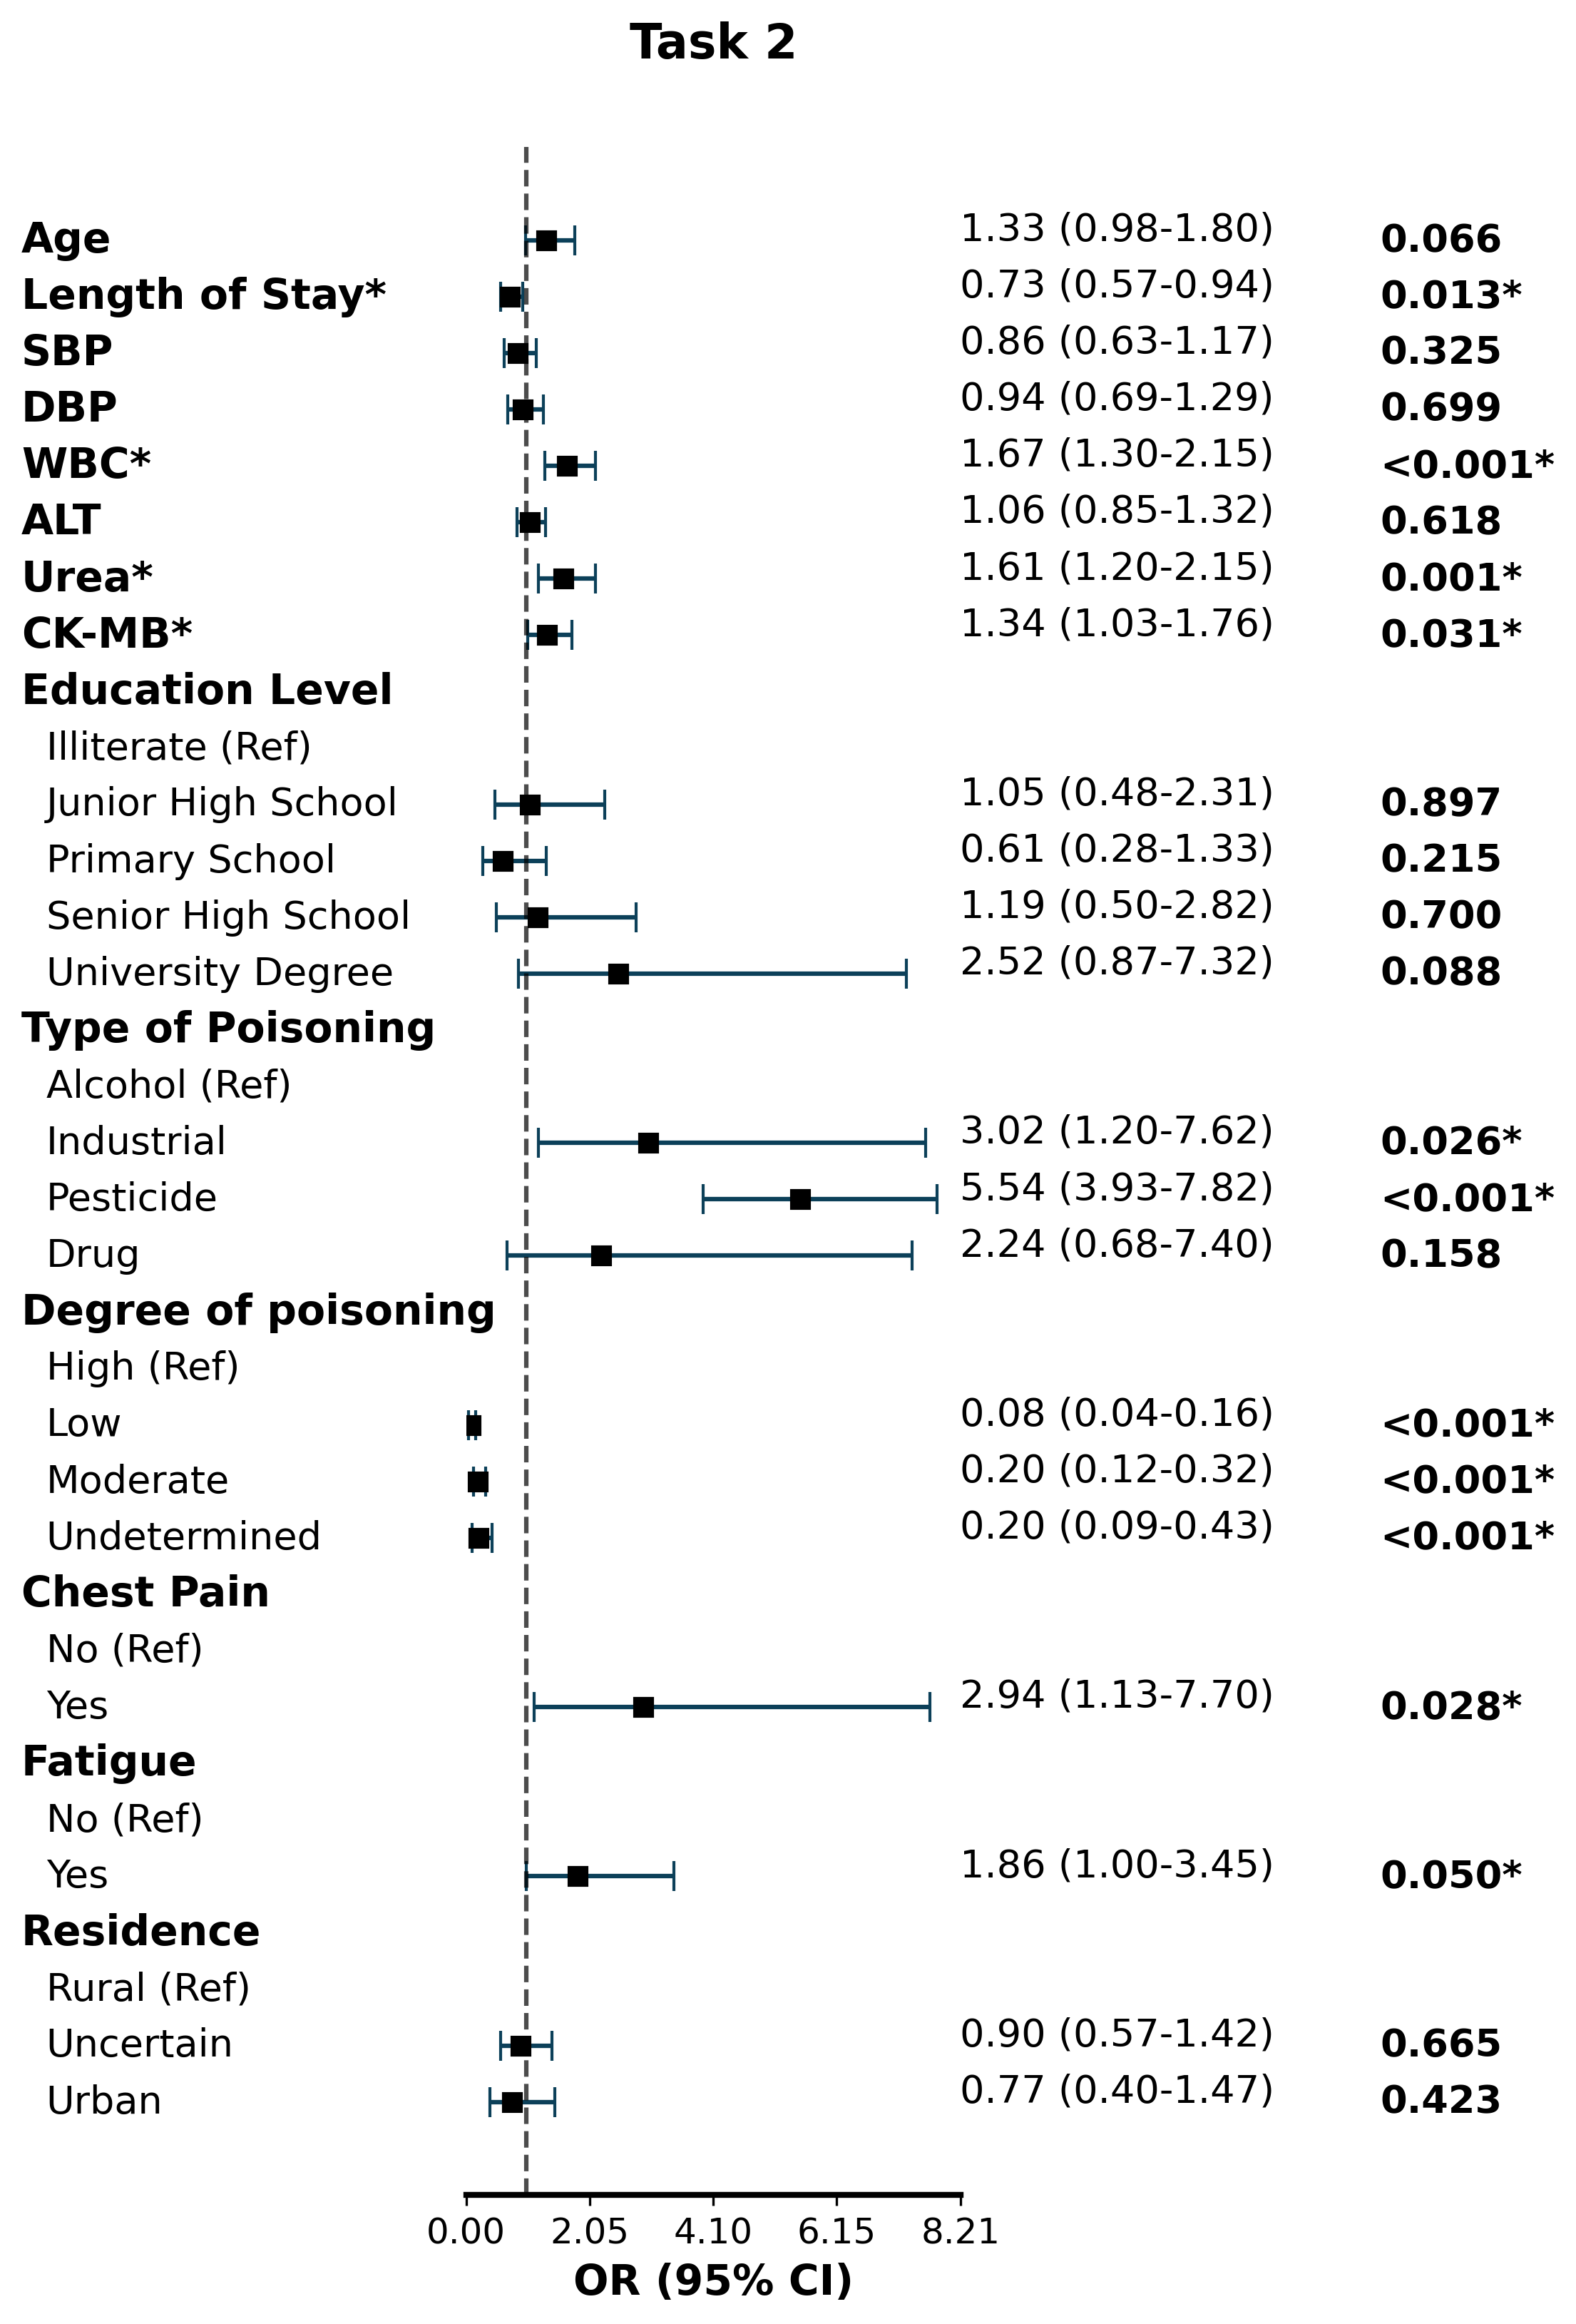

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1. data
# -------------------------
main_variables = main_vars.copy()
subgroups_dict = subgroups_dict.copy()
fixed_values = fixed_values.copy()
p_interactions_data = p_interactions_data.copy()
categorical_p_values = categorical_p_values.copy()

# -------------------------
# 2. structure DataFrame
# -------------------------
plot_data = []
y_counter = 0

for var in main_variables:
    if len(subgroups_dict[var]) == 0:
        plot_data.append({
            'Variable': var,
            'Subgroup': '',
            'OR': fixed_values[var][0][0],
            'CI_Lower': fixed_values[var][0][1],
            'CI_Upper': fixed_values[var][0][2],
            'y_pos': y_counter,
            'ORCI_text': f"{fixed_values[var][0][0]:.2f} ({fixed_values[var][0][1]:.2f}-{fixed_values[var][0][2]:.2f})",
            'P_text': p_interactions_data.get(var, "")
        })
        y_counter += 1
        continue
    plot_data.append({
        'Variable': var,
        'Subgroup': '',
        'OR': None,
        'CI_Lower': None,
        'CI_Upper': None,
        'y_pos': y_counter,
        'ORCI_text': '',
        'P_text': ''
    })
    y_counter += 1
    for idx, sub in enumerate(subgroups_dict[var]):
        p_val = categorical_p_values[var][idx]
        if idx == 0:  
            plot_data.append({
                'Variable': var,
                # 'Subgroup': f"{sub} (Ref)",
                'Subgroup': f"{sub}",
                'OR': None,
                'CI_Lower': None,
                'CI_Upper': None,
                'y_pos': y_counter,
                'ORCI_text': "",
                'P_text': ""
            })
        else:
            or_val, ci_lower, ci_upper = fixed_values[var][idx]
            plot_data.append({
                'Variable': var,
                'Subgroup': sub,
                'OR': or_val,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper,
                'y_pos': y_counter,
                'ORCI_text': f"{or_val:.2f} ({ci_lower:.2f}-{ci_upper:.2f})",
                'P_text': p_val
            })
        y_counter += 1

df_plot = pd.DataFrame(plot_data)

# -------------------------
# 3.Drawing (compact version)
# -------------------------
fig, ax = plt.subplots(figsize=(3, 11),dpi=300)

# 绘制 OR 及 CI
for _, row in df_plot.iterrows():
    if row['OR'] is not None:
        ax.errorbar(
            row['OR'], row['y_pos'],
            xerr=[[row['OR'] - row['CI_Lower']], [row['CI_Upper'] - row['OR']]],
            fmt='s', color='black', ecolor='#0C4059',
            capsize=5, markersize=6, linewidth=1.5
        )

ax.axvline(1, color='black', linestyle='--', alpha=0.7)

import numpy as np

ci_min = df_plot['CI_Lower'].min(skipna=True)
ci_max = df_plot['CI_Upper'].max(skipna=True)
x_margin = 0.05 * (ci_max - ci_min)
x_min = max(0, ci_min - x_margin)
x_max = ci_max + x_margin
ax.set_xlim(x_min, x_max)

xticks_values = np.linspace(x_min, x_max, 5)
ax.set_xticks(xticks_values)
ax.set_xticklabels([f"{v:.2f}" for v in xticks_values], fontsize=12)

ax.set_xlabel("OR (95% CI)", fontsize=14, fontweight='bold')

text_base_x = x_min - 0.9 * (x_max - x_min)
indent = 0.05 * (x_max - x_min)
orci_x = x_max - 0.001 * (x_max - x_min)
p_x = orci_x + 0.85 * (x_max - x_min)

for _, row in df_plot.iterrows():
    if row['Subgroup'] == "":
        ax.text(text_base_x, row['y_pos'], row['Variable'],
                ha='left', va='center', fontsize=14, fontweight='bold')
    else:
        ax.text(text_base_x + indent, row['y_pos'], row['Subgroup'],
                ha='left', va='center', fontsize=13)

for _, row in df_plot.iterrows():
    if row['ORCI_text']:
        ax.text(orci_x, row['y_pos'], row['ORCI_text'], fontsize=13, ha='left')

for _, row in df_plot.iterrows():
    if row['P_text']:
        ax.text(p_x, row['y_pos'], row['P_text'], ha='left', va='center',
                fontsize=13, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)

ax.set_yticks([])
plt.title('Task 2', fontsize=16, fontweight='bold', pad=30)
plt.gca().invert_yaxis()
plt.subplots_adjust(left=0.18, right=0.95, top=0.92, bottom=0.05)
plt.show()


End: add header with visio